# 五. `softmax`回归

## 1. 概述

Softmax回归（Softmax Regression），也称为多项（Multinomial）或多类（Multi-Class）的Logistic回归，是Logistic回归在多分类问题上的推广。

对于多类问题，类别标签$y \in {1, 2,..., C}$ 可以有C个取值．给定一个样本x，Softmax 回归预测的属于类别c的条件概率为
$$
\begin{aligned}
p(y=c|\mathbf{x})&=\mathrm{softmax}(\mathbf{w^T_cx})\\
&=\frac{\exp(\mathbf{w^T_cx})}{\sum_{i=1}^C \exp(\mathbf{w^T_ix})}
\end{aligned}
$$

其中$\mathbf{w_i}$是第i类的权重向量。

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def softmax(X, W):
    """
    X: torch.FloatTensor, N*a, N样本数量, a为特征的维度
    W: torch.FloatTensor, a*C, C为类别数量
    """
    C = torch.exp(X@W)  # hat_y, N*C
    return C / torch.sum(C, axis=1).reshape(X.shape[0], -1)  # 各样本对应类别的标准化概率分布

In [3]:
X = torch.randn(10, 5)
W = torch.randn(5, 3)
softmax(X, W)

tensor([[3.4598e-01, 3.9624e-01, 2.5778e-01],
        [7.1913e-02, 9.2747e-01, 6.1734e-04],
        [6.3532e-02, 9.3405e-01, 2.4192e-03],
        [4.4572e-01, 4.4060e-01, 1.1368e-01],
        [8.8572e-02, 8.9762e-01, 1.3809e-02],
        [1.7300e-01, 5.1218e-03, 8.2188e-01],
        [2.2291e-02, 2.9059e-03, 9.7480e-01],
        [3.6031e-02, 9.0166e-04, 9.6307e-01],
        [3.3506e-01, 7.0396e-02, 5.9455e-01],
        [2.1375e-01, 3.3893e-01, 4.4732e-01]])

## 2. Softmax回归的决策函数

Softmax回归的决策函数可以表示为

$$
\begin{aligned}
\hat{y}&=\text{arg}\max_{i=1}^{C}p(y=c|\mathbf{x})\\
&=\text{arg}\max_{i=1}^{C}\mathbf{w_i^Tx}
\end{aligned}
$$

In [4]:
def hat_y(X, W):
    S = softmax(X, W)  # 各样本在各类别上的概率
    max_indices = torch.max(S, dim=1)[1]
    pred_y = torch.zeros_like(S)
    pred_y[torch.arange(S.shape[0]), max_indices] = 1
    return max_indices, pred_y

In [5]:
pred_y = hat_y(X, W)

In [6]:
pred_y[0]

tensor([1, 1, 1, 0, 1, 2, 2, 2, 2, 2])

In [7]:
pred_y[1]

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

- 与`Logistic`回归的关系。当类别数$C=2$时，softmax回归的决策函数为
$$
\begin{aligned}
\hat{y}&=\text{arg}\max_{i\in\{1,2\}}p(y=c|\mathbf{x})\\
&=\text{arg}\max_{i\in\{1,2\}}\mathbf{w_i^Tx}\\
&=I(\mathbf{(w_2-w_1)^Tx}>0))
\end{aligned}
$$
其中$I(\cdot)$是指示函数。

## 3. 准则

给定N个训练样本，Softmax回归使用交叉熵损失函数学习最有的参数矩阵$W$。为了方便起见，使用C维的`one-hot`向量表示类别标签，对于类别i，其向量表示为
$$
y = [I(i=1), I(i=2), ..., I(i=C)]
$$

采用交叉熵损失函数，Softmax回归模型的风险函数是
$$
\begin{aligned}
R(\mathbf{W})&=-\frac{1}{N}\sum_{n=1}^N\sum_{i=1}^{C}y_i^{(n)}\log \hat{y}_i^{(n)}\\
&=-\frac{1}{N}\sum_{n=1}^N(\mathbf{y^{(n)}})^T\log \hat{y}_c^{(n)}
\end{aligned}
$$
其中，$\hat{y}_c^{(n)}=\text{softmax}(\mathbf{W^Tx^{(n)}})$为样本$x^{(n)}$在每个类别的后验概率。

In [8]:
def cross_entropy(X, y, W):
    """
    X: N*(a+1), N个样本, 特征数量为为a, 外加1维偏置
    y: N*C, y为N个C维的one-hot向量
    W: (a+1)*C
    """
    p_y = softmax(X, W) # N*C, N个样本分别在C个类别的后验概率
    crossEnt = -torch.dot(y.reshape(-1), torch.log2(p_y).reshape(-1)) / y.shape[0]  # 展开成1维，点积
    return crossEnt

In [9]:
X = torch.randn(10, 5)
y = torch.zeros(10, 3)
y[torch.arange(10), torch.randint(low=0, high=y.shape[1] - 1, size=(10,))] = 1  # 随机取1行中的某个元素为1，即确定1个样本对应的类别
W = torch.randn(5, 3)

In [10]:
a = torch.arange(10)
b = torch.arange(10)

torch.sum(a * b), torch.dot(a,b)

(tensor(285), tensor(285))

In [11]:
y  # 真实标签

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])

In [12]:
cross_entropy(X, y, W)

tensor(1.8494)

In [13]:
prob_y = softmax(X, W)

In [14]:
-torch.log2(prob_y)

tensor([[8.6241e-04, 1.1254e+01, 1.2376e+01],
        [1.0368e+01, 7.9855e-01, 1.2368e+00],
        [2.1208e+00, 1.2259e+00, 1.5457e+00],
        [2.8011e-02, 5.8849e+00, 8.7603e+00],
        [6.1275e-01, 1.8015e+00, 4.0790e+00],
        [3.0443e+00, 2.1828e+00, 6.0268e-01],
        [4.9242e-02, 4.9325e+00, 1.0272e+01],
        [5.8039e+00, 3.4604e+00, 1.6609e-01],
        [3.0465e-01, 2.9941e+00, 3.9468e+00],
        [2.5823e+00, 7.3544e-01, 2.1054e+00]])

In [15]:
-torch.dot(y.reshape(-1), torch.log2(prob_y).reshape(-1)) / y.shape[0]

tensor(1.8494)

- 风险函数$\mathbf{R(W)}$关于$W$的梯度为
$$
\frac{\partial R(W)}{\partial W}=-\frac{1}{N}\sum_{n=1}^N\mathbf{x^{(n)}(y^{(n)}-\hat{y}^{(n)})}^T
$$

In [16]:
def grad_crosEnt_W(X, y, W):
    '''
    X: N*(a+1), N个样本, 特征数量为为a, 外加1维偏置
    y: N*C, y为N个C维的one-hot向量
    W: (a+1)*C
    '''
    hat_y = softmax(X, W)
    a = (X.t() @ (y - hat_y)) / y.shape[0]  # (a+1)*N | N*C
    return -a

In [17]:
grad_crosEnt_W(X, y, W)

tensor([[-0.0322,  0.0375, -0.0053],
        [ 0.0408, -0.0337, -0.0071],
        [-0.2919,  0.1514,  0.1406],
        [ 0.1522,  0.0413, -0.1935],
        [-0.0409,  0.0083,  0.0326]])

## 4. 学习方法

- 输入: 训练集X，`one-hot`形式的标签y
- 输出：最优参数$w^*$
- 算法过程
    - 初始化$W_0:=0$，最大迭代次数$T$
    - 然后通过下式进行参数的迭代更新
    $$
    W_{t+1}:=W_t+\eta\left(\frac{1}{N}\sum_{n=1}^N\mathbf{x^{(n)}(y^{(n)}-\hat{y}^{(n)})}^T\right) 
    $$
    - 直到满足指定迭代次数，令$w^*=w^T$。

- 预测的正确率

In [18]:
def precision_rate(X, y, W, X_with_bias=False):
    if X_with_bias:
        hat_X = X
    else:
        hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)  # 增广X
        
    pred_y = hat_y(hat_X, W)
    precision = torch.sum(pred_y[0] == torch.max(y, axis=1)[1]).numpy() / pred_y[0].numel()
    return precision

- 生成模拟数据

In [19]:
X = torch.randn(1000, 8)
hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)  # 增广
true_W = torch.randn(hat_X.shape[1], 5)  # 增广
indices_y, y = hat_y(hat_X, true_W)

In [20]:
train_X, train_y = X[:800], y[:800]
train_indices_y = indices_y[:800]
hat_train_X = hat_X[:800]
test_X, test_y = X[800:], y[800:]
test_indices_y = indices_y[800:]
hat_test_X = hat_X[800:]

### 4.1 方法1: 梯度下降-人工求导

In [21]:
def softmax_sgd(X, y, num_steps=100, lr=0.1):
    '''
    X: N*(a+1), N个样本, 特征数量为为a, 外加1维偏置
    y: N*C, y为N个C维的one-hot向量
    W: (a+1)*C
    '''
    hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)  # 增广X
    W = torch.randn(hat_X.shape[1], y.shape[1])  # 增广参数矩阵
    for i in range(num_steps):
        W -= lr*grad_crosEnt_W(hat_X, y, W)
        loss = cross_entropy(hat_X, y, W)
        if (i+1) % 50 == 0:
            print(f'训练{i+1}轮, 交叉熵为{loss:.2f}')
            
    return W

In [22]:
# 模拟数据
est_W = softmax_sgd(train_X, train_y, num_steps=1000)
precision_rate(train_X, train_y, est_W, X_with_bias=False), precision_rate(test_X, test_y, est_W, X_with_bias=False)

训练50轮, 交叉熵为1.90
训练100轮, 交叉熵为1.05
训练150轮, 交叉熵为0.76
训练200轮, 交叉熵为0.64
训练250轮, 交叉熵为0.57
训练300轮, 交叉熵为0.52
训练350轮, 交叉熵为0.49
训练400轮, 交叉熵为0.46
训练450轮, 交叉熵为0.44
训练500轮, 交叉熵为0.42
训练550轮, 交叉熵为0.41
训练600轮, 交叉熵为0.40
训练650轮, 交叉熵为0.38
训练700轮, 交叉熵为0.37
训练750轮, 交叉熵为0.36
训练800轮, 交叉熵为0.36
训练850轮, 交叉熵为0.35
训练900轮, 交叉熵为0.34
训练950轮, 交叉熵为0.33
训练1000轮, 交叉熵为0.33


(0.96, 0.935)

### 4.2 方法2: 随机梯度下降-自动求导

In [23]:
def softmax_miniBatch_sgd(X, y, num_epoch=50, batch_size=40, lr=0.05):
    '''
    X: N*a, N个样本, 特征数量为为a
    y: N*C, y为N个C维的one-hot向量
    W: a*C
    '''
    hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)  # 增广X
    W = torch.randn(hat_X.shape[1], y.shape[1])  # 增广参数矩阵
    W.requires_grad_()
    dataset = TensorDataset(hat_X, y)
    data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epoch):
        for t_x, t_y in data_iter:
            l = cross_entropy(t_x, t_y, W)        
            l.backward()  # 计算损失函数在 W 上的梯度
            W.data.sub_(lr*W.grad/batch_size)
            W.grad.data.zero_()
            
        if (epoch + 1) % 50 == 0:
            with torch.no_grad():  # 不计算梯度，加速损失函数的运算
                train_l = cross_entropy(hat_X, y, W)  # 最近一次的负对数似然率
                est_W = W.detach().numpy()  # detach得到一个有着和原tensor相同数据的tensor
                print(f'epoch {epoch + 1}, loss: {train_l:.4f}')
            
    return est_W, train_l

In [24]:
# 模拟数据
est_W, train_l = softmax_miniBatch_sgd(train_X, train_y, num_epoch=1000, batch_size=40, lr=0.1)
precision_rate(train_X, train_y, est_W), precision_rate(test_X, test_y, est_W)

epoch 50, loss: 2.6921
epoch 100, loss: 1.4816
epoch 150, loss: 0.9564
epoch 200, loss: 0.7273
epoch 250, loss: 0.6169
epoch 300, loss: 0.5552
epoch 350, loss: 0.5157
epoch 400, loss: 0.4876
epoch 450, loss: 0.4660
epoch 500, loss: 0.4485
epoch 550, loss: 0.4337
epoch 600, loss: 0.4210
epoch 650, loss: 0.4097
epoch 700, loss: 0.3996
epoch 750, loss: 0.3905
epoch 800, loss: 0.3821
epoch 850, loss: 0.3745
epoch 900, loss: 0.3674
epoch 950, loss: 0.3608
epoch 1000, loss: 0.3547


(0.955, 0.93)

### 4.3 方法3: torch.nn

- 定义类

In [25]:
class SofmaxRegresModel(torch.nn.Module): 
    def __init__(self, dim_in, dim_out):
        # 首先找到LinearModel的父类torch.nn.Module，然后把类LinearModel的对象转换为类torch.nn.Module的对象, 
        # 即执行父类torch.nn.Module的初始化__init__()
        super(SofmaxRegresModel, self).__init__() 
        self.layer1 = torch.nn.Linear(dim_in, dim_out, bias=True)
        
    def forward(self, x):
        y_pred = self.layer1(x)
        return torch.nn.functional.softmax(y_pred, dim=1)  # softmax

- 定义训练算法

In [48]:
X.shape, y.shape

(torch.Size([1000, 8]), torch.Size([1000, 5]))

In [26]:
dim_in = X.shape[1]
dim_out = y.shape[1]
# 实例化1个网络
net = SofmaxRegresModel(dim_in, dim_out)
# 初始化网络参数和偏置
net.layer1.weight.data = torch.randn(dim_out, dim_in)
net.layer1.bias.data = torch.Tensor(dim_out)
# 损失函数
loss = torch.nn.CrossEntropyLoss()
# 随机梯度下降算法
trainer = torch.optim.SGD(net.parameters(), lr=0.05)

In [27]:
# 加载数据
batch_size = 20
num_epochs = 200
dataset = TensorDataset(train_X, train_indices_y)
data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# 开始训练
for epoch in range(num_epochs):
    for t_x, t_y in data_iter:
        l = loss(net(t_x), t_y)  # 计算当前批量的交叉熵损失
        trainer.zero_grad()  # 参数梯度清零
        l.backward()  # 反向传播，计算梯度
        trainer.step()  # 更新参数
        
    if (epoch+1) % 20 == 0:
        with torch.no_grad():  # 不计算梯度，加速损失函数的运算
            l_epoch = loss(net(train_X), train_indices_y) 
            print('epoch {}, loss {}'.format(epoch+1, l_epoch)) 

epoch 20, loss 1.370640754699707
epoch 40, loss 1.1573972702026367
epoch 60, loss 1.0841116905212402
epoch 80, loss 1.0599939823150635
epoch 100, loss 1.0462019443511963
epoch 120, loss 1.0364203453063965
epoch 140, loss 1.0288468599319458
epoch 160, loss 1.0227004289627075
epoch 180, loss 1.0175586938858032
epoch 200, loss 1.0131640434265137


- 结果

In [28]:
w, b = net.parameters()
W = torch.cat([w.data, b.data.reshape(-1, 1)], axis=1)

pred_train_y = torch.max(net(train_X), axis=1)[1]
pred_test_y = torch.max(net(test_X), axis=1)[1]

print('train', torch.sum(pred_train_y == train_indices_y).numpy() / train_indices_y.numel())
print('test', torch.sum(pred_test_y == test_indices_y).numpy() / test_indices_y.numel())

train 0.97
test 0.945


## 5. 案例

鸢尾花数据集

In [29]:
from sklearn import datasets
d = datasets.load_iris()

In [56]:
print(d.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [30]:
x_labels, y_labels = d['feature_names'], d['target_names']

In [31]:
x_labels, y_labels

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [32]:
rand_idx = np.arange(len(d['target']))  # 样本下标
np.random.shuffle(rand_idx)  # 打乱样本下标
t_idx = rand_idx[:100]  # 训练集下标
v_idx = rand_idx[100:]  # 测试集下标
x_train, y_train = torch.from_numpy(d['data'][t_idx]).type(torch.FloatTensor), torch.from_numpy(d['target'][t_idx])  # 训练集
x_valid, y_valid = torch.from_numpy(d['data'][v_idx]).type(torch.FloatTensor), torch.from_numpy(d['target'][v_idx])  # 测试集
onehot_y_train = torch.zeros(x_train.shape[0], 3)  # 训练集标签转为one-hot向量
onehot_y_train[torch.arange(x_train.shape[0]), y_train] = 1
onehot_y_valid = torch.zeros(x_valid.shape[0], 3)  # 预测集标签转为one-hot向量
onehot_y_valid[torch.arange(x_valid.shape[0]), y_valid] = 1

In [33]:
y_train

tensor([2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2,
        0, 2, 2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 0, 1, 0, 0, 2,
        2, 2, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 1,
        0, 1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2,
        1, 2, 0, 2])

In [34]:
onehot_y_train

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1

### 5.1 方法1

In [35]:
est_W = softmax_sgd(x_train, onehot_y_train, num_steps=1000)
print(f"Train accuracy rate: {precision_rate(x_train, onehot_y_train, est_W)}")
print(f"Valid accuracy rate: {precision_rate(x_valid, onehot_y_valid, est_W)}")

训练50轮, 交叉熵为1.04
训练100轮, 交叉熵为0.81
训练150轮, 交叉熵为0.62
训练200轮, 交叉熵为0.46
训练250轮, 交叉熵为0.39
训练300轮, 交叉熵为0.35
训练350轮, 交叉熵为0.33
训练400轮, 交叉熵为0.31
训练450轮, 交叉熵为0.29
训练500轮, 交叉熵为0.27
训练550轮, 交叉熵为0.26
训练600轮, 交叉熵为0.25
训练650轮, 交叉熵为0.24
训练700轮, 交叉熵为0.23
训练750轮, 交叉熵为0.23
训练800轮, 交叉熵为0.22
训练850轮, 交叉熵为0.21
训练900轮, 交叉熵为0.21
训练950轮, 交叉熵为0.20
训练1000轮, 交叉熵为0.20
Train accuracy rate: 0.97
Valid accuracy rate: 0.98


### 5.2 方法2 

In [36]:
# 鸢尾花
est_W, _ = softmax_miniBatch_sgd(x_train, onehot_y_train, num_epoch=1000, batch_size=40, lr=0.1)
print(f"Train accuracy rate: {precision_rate(x_train, onehot_y_train, est_W)}")
print(f"Valid accuracy rate: {precision_rate(x_valid, onehot_y_valid, est_W)}")

epoch 50, loss: 0.8281
epoch 100, loss: 0.7560
epoch 150, loss: 0.7091
epoch 200, loss: 0.6748
epoch 250, loss: 0.6482
epoch 300, loss: 0.6265
epoch 350, loss: 0.6082
epoch 400, loss: 0.5922
epoch 450, loss: 0.5780
epoch 500, loss: 0.5651
epoch 550, loss: 0.5533
epoch 600, loss: 0.5424
epoch 650, loss: 0.5326
epoch 700, loss: 0.5228
epoch 750, loss: 0.5141
epoch 800, loss: 0.5052
epoch 850, loss: 0.4972
epoch 900, loss: 0.4897
epoch 950, loss: 0.4823
epoch 1000, loss: 0.4755
Train accuracy rate: 0.9
Valid accuracy rate: 0.96


### 5.3 方法3

In [55]:
# 实例化
dim_in = 4  # 特征数量
dim_out = 3  # 类别数量
net = SofmaxRegresModel(dim_in, dim_out)
# 初始化网络参数和偏置
net.layer1.weight.data = torch.randn(dim_out, dim_in)
net.layer1.bias.data = torch.randn(dim_out)
# 损失函数
loss = torch.nn.CrossEntropyLoss()
# 随机梯度下降算法
trainer = torch.optim.SGD(net.parameters(), lr=0.01)
# 加载数据
batch_size = 100
num_epochs = 2000
dataset = TensorDataset(x_train, y_train)
data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [56]:
# 训练
for epoch in range(num_epochs):
    for t_x, t_y in data_iter:
        l = loss(net(t_x), t_y)  # 计算当前批量的交叉熵损失
        trainer.zero_grad()  # 参数梯度清零
        l.backward()  # 反向传播，计算梯度
        trainer.step()  # 更新参数
    if (epoch+1) % 50 == 0:
        with torch.no_grad():  # 不计算梯度，加速损失函数的运算
            l_epoch = loss(net(x_train), y_train) 
            print('epoch {}, loss {}'.format(epoch+1, l_epoch)) 

epoch 50, loss 1.2578121423721313
epoch 100, loss 1.2572717666625977
epoch 150, loss 1.25655996799469
epoch 200, loss 1.255589485168457
epoch 250, loss 1.254209041595459
epoch 300, loss 1.25214421749115
epoch 350, loss 1.2488677501678467
epoch 400, loss 1.2433182001113892
epoch 450, loss 1.2329506874084473
epoch 500, loss 1.204219937324524
epoch 550, loss 1.1108458042144775
epoch 600, loss 1.0970641374588013
epoch 650, loss 1.0919201374053955
epoch 700, loss 1.086928367614746
epoch 750, loss 1.082106590270996
epoch 800, loss 1.0775548219680786
epoch 850, loss 1.073352575302124
epoch 900, loss 1.0695500373840332
epoch 950, loss 1.0661671161651611
epoch 1000, loss 1.0631977319717407
epoch 1050, loss 1.0606169700622559
epoch 1100, loss 1.0583884716033936
epoch 1150, loss 1.0564707517623901
epoch 1200, loss 1.054821491241455
epoch 1250, loss 1.0534014701843262
epoch 1300, loss 1.0521749258041382
epoch 1350, loss 1.051110863685608
epoch 1400, loss 1.0501829385757446
epoch 1450, loss 1.04936

In [57]:
w, b = net.parameters()
W = torch.cat([w.data, b.data.reshape(-1, 1)], axis=1)

In [58]:
pred_y_train = torch.max(net(x_train), axis=1)[1]
pred_y_valid = torch.max(net(x_valid), axis=1)[1]

In [59]:
pred_y_train

tensor([2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2,
        1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2,
        2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1,
        1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2,
        1, 2, 1, 2])

In [60]:
torch.sum(pred_y_train == y_train).numpy() / y_train.numel()

0.53

In [61]:
torch.sum(pred_y_valid == y_valid).numpy() / y_valid.numel()

0.46

## 附. 熵相关概念

一条信息的信息量大小和它的不确定性有很大的关系。一句话如果需要很多外部信息才能确定，我们就称这句话的信息量比较大。比如你听到“云南西双版纳下雪了”，那你需要去看天气预报、问当地人等等查证（因为云南西双版纳从没下过雪）。相反，如果和你说“人一天要吃三顿饭”，那这条信息的信息量就很小，因为这条信息的确定性很高，我们不需要用很多信息取证明它。因此，可将事件$x_0$的信息量表示为：
$$
I(x_0)=-\log p(x_0)
$$
> 一条信息信息量的大小与其发生概率（不确定性越小，发生概率越大）呈反比，概率越大，信息量越小

### A1. 熵
信息量是对于单个事件来说的，但是实际情况一件事有很多种发生的可能，比如掷骰子有可能出现6种情况，明天的天气可能晴、多云或者下雨等等。因此，我们需要评估事件对应的所有可能性。

熵（entropy）是表示随机变量不确定的度量，是对表征所有可能发生的事件所需信息量的期望。

设$X$是一个取有限个值的随机变量，其概率分布为
$$
P(X=x_i)=p_i,i=1,2,...,n
$$
熵定义为
$$
H(x)=\sum_{i=0} p(x_i) I(x_i)=-\sum_{i=1}^n p(x_i) \log p(x_i)
$$
上式中，若$p_i=0$，则定义$0\log 0=0$；对数以2或者e为底，这时熵的单位分别称为比特(bit)或者纳特(nat)。熵只依赖于$X$的分布，与其取值无关，因此也可将$X$的熵记作$H(p)$, 即
$$
H(p)=-\sum_{i=1}^n p_i \log p_i
$$
熵越大，不确定越大。

In [18]:
def entropy(P):
    '''
    P为概率分布
    '''
    return -np.sum([p*np.log2(p) if p > 0 else 0 for p in P])

In [19]:
P1 = np.ones(10) / 10
P2 = np.zeros(10)
P2[3] = 1
entropy(P1), entropy(P2)

(3.321928094887362, -0.0)

In [20]:
P1

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [22]:
P3 = np.array([0, 0.1, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 0.1, 0])

In [23]:
entropy(P3)

2.9219280948873623

In [21]:
P2

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

### A2. 条件熵
条件熵(conditional entropy): 表示在已知随机变量$X$的条件下随机变量$Y$的不确定性。

$$
H(Y|X)=\sum_{i=1}^n P(X=x_i)H(Y|X=x_i)
$$

其中，$H(Y|X=x_i)=-\sum_j P(Y=y_j|X=x_i)\log P(Y=y_j|X=x_i)$，表示在$X=x_i$时Y的不确定程度；$p(Y=y_j|X=x_i) = \frac{p(X=x_i, Y=y_j)}{p(X=x_i)}$。
> 如果X与Y无关，则有$H(Y|X)=H(Y)$；如果Y由X唯一决定，则有$H(Y|X)=0$

In [24]:
def conditional_entropy(P_XY):
    '''
    P_XY为X和Y的联合概率分布shape(x_size, y_z)
    '''
    return np.sum([np.sum(P_XY[i]) * entropy(P_XY[i, :]/np.sum(P_XY[i])) 
                   for i in P_XY.shape[1]])

### A3. KL散度（相对熵）

相对熵(`relative entropy`)或KL散度(`Kullback-Leibler divergence`)：度量一个概率分布$p(x)$相对另一个概率分布$q(X)$的差异

$$
\text{KL(p||q)}=-\sum_x p(x)\log\frac{q(x)}{p(x)}
$$

由`Jesen`不等式可证明，$\text{KL(p||q)}\geq 0$，当且仅当对于所有$x$有$p(x)=q(x)$时，取等号。

此外，需注意，$\text{KL(p||q)}\neq \text{KL(q||p)}$

In [25]:
def KL(p_x, q_x):
    return -np.sum([p_x[i]*np.log(q_x[i]/p_x[i]) if p_x[i] > 0 and q_x[i] > 0 else 0 
                    for i in range(len(p_x))])

In [27]:
KL(P1, P2), KL(P1, P1), KL(P2, P1)

(-0.2302585092994046, -0.0, 2.3025850929940455)

### A4. 交叉熵

交叉熵定义如下:

$$
\text{crossEntropy(p(x), q(x))} = -\sum_x p(x)\log q(x)
$$

- 与KL散度的关系
$$
\begin{aligned}
\text{KL(p||q)} &= -\sum_x p(x)\log\frac{q(x)}{p(x)}\\
&= -\sum_x p(x)\log q(x) + \sum_x p(x)\log p(x) \\
&= \text{crossEntropy(p(x), q(x))} - H\left(p(x)\right)
\end{aligned}
$$

即有$\text{crossEntropy(p(x), q(x))} = \text{KL(p||q)} + H\left(p(x)\right)$

由于$H\left(p(x)\right)$为定值，针对q最小化交叉熵等价于最小化`KL(p||q)`，即使理论分布与抽样分布之间的差异最小。

In [28]:
def cross_entropy(p_x, q_x):
    return -np.sum([p_x[i]*np.log(q_x[i]) if q_x[i] > 0 else 0 for i in range(len(p_x))])

In [29]:
cross_entropy(P1, P2), cross_entropy(P1, P1), cross_entropy(P2, P2)

(-0.0, 2.3025850929940455, -0.0)

## 参考资料
1. 李航. 统计学习方法. 2017.
2. 邱锡鹏. 神经网络与机器学习. 2020.

In [190]:
def f(pnovel, arc=3, rho=0.5, w=3, k=6):
    a = w * (1- pnovel)
    b1 = (1 - pnovel)**2 * arc * (k*rho - w)
    b2 = pnovel + (1 - pnovel) * arc
    return (arc/k) * (a + b1 / b2)

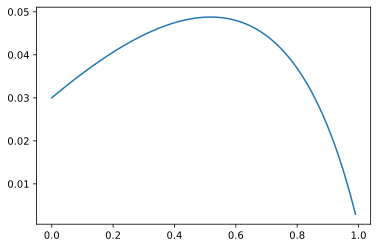

In [242]:
pnovel = np.arange(0, 1, step=0.01)
y = f(pnovel, arc=3, rho=0.01, w=0.6, k=6)
plt.plot(pnovel, y)

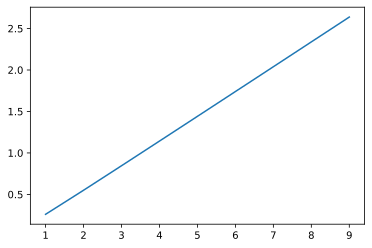

In [243]:
pnovel = 0.4
arc = np.arange(1, 10, step=1)
y = f(pnovel, arc=arc, rho=0.5, w=1, k=3)
plt.plot(arc, y)

In [209]:
def w(t, d):
    return np.exp(-0.4*(t - d)**0.4)

(0.0, 1.0)

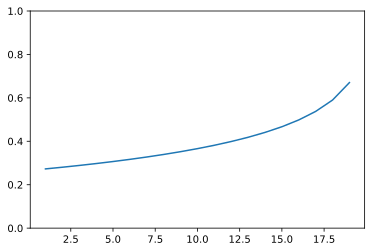

In [218]:
t = 20
d = np.arange(1, t, 1)
plt.plot(d, w(t, d))
plt.ylim([0, 1])